In [1]:
import asyncio
import logging
import os
import time
import urllib
import warnings

import awkward as ak
from coffea.nanoevents import NanoAODSchema
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms, NanoEventsFactory
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 10

# pipeline to use:
# - "coffea" for pure coffea setup
# - "servicex_processor" for coffea with ServiceX processor
# - "servicex_databinder" for downloading query output and subsequent standalone coffea
PIPELINE = "coffea"

# enable Dask (may not work yet in combination with ServiceX outside of coffea-casa)
USE_DASK = True

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = False

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
AF_NAME = "coffea_casa"  # "ssl-dev" allows for the switch to local data on /data
SYSTEMATICS = "all"  # currently has no effect
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

# only I/O, all other processing disabled
DISABLE_PROCESSING = False

# read additional branches (only with DISABLE_PROCESSING = True)
# acceptable values are 4, 15, 25, 50 (corresponding to % of file read), 4% corresponds to the standard branches used in the notebook
IO_FILE_PERCENT = 4

In [3]:
processor_base = processor.ProcessorABC if (PIPELINE != "servicex_processor") else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 2.5% weight variations
    return (1.0 + np.array([0.025, -0.025], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (7.5% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.075, -0.075]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor_base):
    def __init__(self, disable_processing, io_file_percent, filetype="miniAOD"):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
        self.disable_processing = disable_processing
        self.io_file_percent = io_file_percent
        self.filetype = filetype

    def only_do_IO(self, events):
            if self.filetype == "nanoAOD":
                branches_to_read = ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagCSVV2", "Jet_energy", "Muon_pt", "Electron_pt"]
            else:
                branches_to_read = ["jet_pt", "jet_eta", "jet_phi", "jet_btag", "jet_e", "muon_pt", "electron_pt"]
            
            if self.io_file_percent not in [4, 15, 25, 50] and filetype=="miniAOD":
                raise NotImplementedError("supported values for I/O percentage (miniAOD) are 4, 15, 25, 50")
            if self.io_file_percent not in [4] and filetype=="nanoAOD":
                raise NotImplementedError("supported values for I/O percentage (nanoAOD) are 4")
            if self.io_file_percent >= 15 and filetype=="miniAOD":
                branches_to_read += ["trigobj_e"]
            if self.io_file_percent >= 25 and filetype=="miniAOD":
                branches_to_read += ["trigobj_pt"]
            if self.io_file_percent >= 50 and filetype=="miniAOD":
                branches_to_read += ["trigobj_eta", "trigobj_phi", "jet_px", "jet_py", "jet_pz", "jet_ch"]

            for branch in branches_to_read:
                if "_" in branch:
                    object_type, property_name = branch.split("_")
                    if property_name == "e":
                        property_name = "energy"
                    ak.materialized(events[object_type][property_name])
                else:
                    ak.materialized(events[branch])
            return {"hist": {}}

    def process(self, events):
        if self.disable_processing:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # example of a simple flat weight variation, using the coffea nanoevents systematics feature
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        
        if self.filetype=="nanoAOD":
            events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)
        else:
            events["pt_res_up"] = jet_pt_resolution(events.jet.pt)

        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:

            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            if self.filetype=="nanoAOD":
                selected_electrons = events.Electron[events.Electron.pt > 25]
                selected_muons = events.Muon[events.Muon.pt > 25]
                jet_filter = events.Jet.pt * events[pt_var] > 25 
                selected_jets = events.Jet[jet_filter]
                
            else:
                selected_electrons = events.electron[events.electron.pt > 25]
                selected_muons = events.muon[events.muon.pt > 25]
                jet_filter = events.jet.pt * events[pt_var] > 25 
                selected_jets = events.jet[jet_filter]

            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            
            if self.filetype=="nanoAOD":
                event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            else:
                event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)
                
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    
                    if self.filetype=="nanoAOD":
                        region_filter = ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1
                    else:
                        region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                    
                    selected_jets_region = selected_jets[region_filter]
                    
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = (
                        events[event_filters][region_filter][pt_var]
                        if "res" not in pt_var
                        else events[pt_var][jet_filter][event_filters][region_filter]
                    )
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

                elif region == "4j2b":
                    
                    if self.filetype=="nanoAOD":
                        region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
                    else:
                        region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                    
                    selected_jets_region = selected_jets[region_filter]

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    
                    if self.filetype=="nanoAOD":
                        trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    else:
                        trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                    
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process,
                            variation=variation, weight=xsec_weight
                        )

                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][
                                    f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                if len(observable):
                                    weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, i_dir]
                                else:
                                    weight_variation = 1 # no events selected
                                histogram.fill(
                                    observable=observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process,
                            variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        #output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        #output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [5]:
fileset_mini = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                       use_xcache=False, 
                                       af_name=AF_NAME)

fileset_nano = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                       use_xcache=False, 
                                       af_name=AF_NAME, 
                                       json_file="ntuples_nanoaod_agc.json")

process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
process =  wjets
variation =  nominal
process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  DS
process =  wjets
variation =  nominal


In [6]:
if PIPELINE == "coffea":
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.FuturesExecutor(workers=NUM_CORES)

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

    filemeta = run.preprocess(fileset_mini, treename="events")  # pre-processing

    t0 = time.monotonic()
    all_histograms, metrics = run(fileset_mini, "events", processor_instance=TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT, filetype="miniAOD"))  # processing
    exec_time = time.monotonic() - t0
    all_histograms_mini = all_histograms["hist"]

In [7]:
if PIPELINE == "coffea":
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.FuturesExecutor(workers=NUM_CORES)

    run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

    filemeta = run.preprocess(fileset_nano, treename="Events")  # pre-processing

    t0 = time.monotonic()
    all_histograms, metrics = run(fileset_nano, "Events", processor_instance=TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT, filetype="nanoAOD"))  # processing
    exec_time = time.monotonic() - t0
    all_histograms_nano = all_histograms["hist"]

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


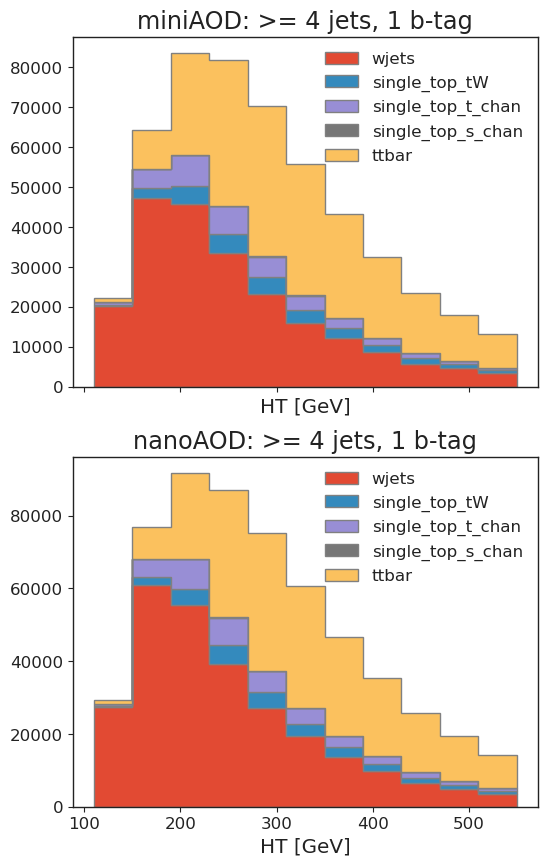

In [14]:
utils.set_style()

fig,axs = plt.subplots(2,1,figsize=(6,10),sharex=True)

all_histograms_mini[120j::hist.rebin(2), 
                    "4j1b", 
                    ["ttbar","single_top_s_chan","single_top_t_chan","single_top_tW","wjets"], 
                    "nominal"
                   ].stack("process")[::-1].plot(stack=True, 
                                                 histtype="fill", 
                                                 linewidth=1, 
                                                 edgecolor="grey",
                                                 ax=axs[0])
axs[0].legend(frameon=False)
axs[0].set_title("miniAOD: >= 4 jets, 1 b-tag")
axs[0].set_xlabel("HT [GeV]")

all_histograms_nano[120j::hist.rebin(2), 
                    "4j1b", 
                    ["ttbar","single_top_s_chan","single_top_t_chan","single_top_tW","wjets"], 
                    "nominal"
                   ].stack("process")[::-1].plot(stack=True, 
                                                 histtype="fill", 
                                                 linewidth=1, 
                                                 edgecolor="grey",
                                                 ax=axs[1])
axs[1].legend(frameon=False)
axs[1].set_title("nanoAOD: >= 4 jets, 1 b-tag")
axs[1].set_xlabel("HT [GeV]")

plt.show()

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


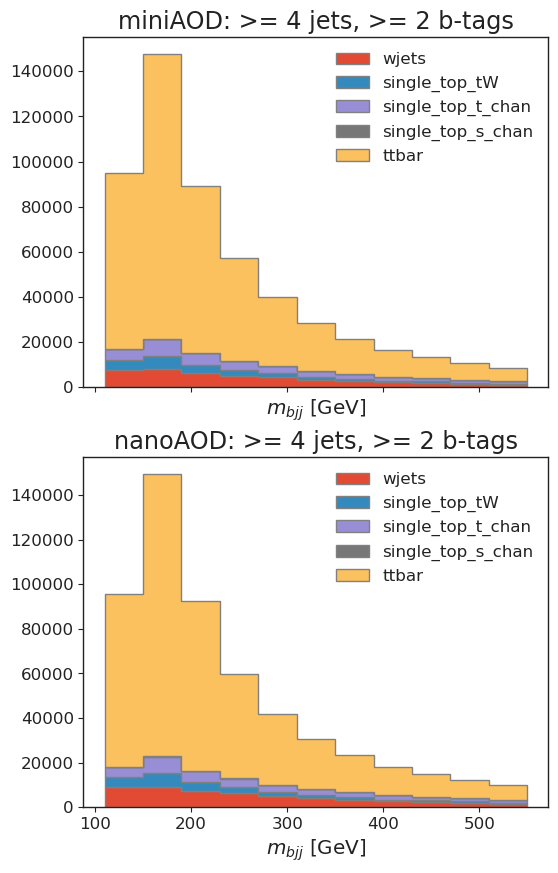

In [15]:
utils.set_style()

fig,axs = plt.subplots(2,1,figsize=(6,10),sharex=True)

all_histograms_mini[120j::hist.rebin(2), 
                    "4j2b", 
                    ["ttbar","single_top_s_chan","single_top_t_chan","single_top_tW","wjets"], 
                    "nominal"
                   ].stack("process")[::-1].plot(stack=True, 
                                                 histtype="fill", 
                                                 linewidth=1, 
                                                 edgecolor="grey",
                                                 ax=axs[0])
axs[0].legend(frameon=False)
axs[0].set_title("miniAOD: >= 4 jets, >= 2 b-tags")
axs[0].set_xlabel("$m_{bjj}$ [GeV]")

all_histograms_nano[120j::hist.rebin(2), 
                    "4j2b", 
                    ["ttbar","single_top_s_chan","single_top_t_chan","single_top_tW","wjets"], 
                    "nominal"
                   ].stack("process")[::-1].plot(stack=True, 
                                                 histtype="fill", 
                                                 linewidth=1, 
                                                 edgecolor="grey",
                                                 ax=axs[1])
axs[1].legend(frameon=False)
axs[1].set_title("nanoAOD: >= 4 jets, >= 2 b-tags")
axs[1].set_xlabel("$m_{bjj}$ [GeV]")

plt.show()

In [16]:
hist1 = all_histograms_mini[:, :, "single_top_t_chan", "nominal",:,:].project("leptonpt")
hist2 = all_histograms_nano[:, :, "single_top_t_chan", "nominal",:,:].project("leptonpt")

print("Sum of Hist 1 = ", hist1.sum())
print("Sum of Hist 2 = ", hist2.sum())

main_ax_artists, sublot_ax_artists = hist1.plot_ratio(hist2, 
                                                      rp_num_label="miniAOD",
                                                      rp_denom_label="nanoAOD")

plt.show()

IndexError: Wrong number of indices for histogram